# Introduction to Ray AI Runtime (AIR)
---
(*Suggested Time to Complete: 30 minutes*)

Welcome to Part II of "Introduction to Ray"!

![Map of Ray](../_static/assets/Introduction_to_Ray_AIR/map.png)

*Figure 1*

Ray AI Runtime (AIR) is a unified set of libraries built on top of Ray for distributed data processing, model training, tuning, model serving, and reinforcement learning, all in Python. AIR provides simple scalable machine learning for individual workloads and end-to-end workflows, bringing together an ever-growing ecosystem of integrations with your favorite machine learning frameworks.

Before we lay out each library and their unique jobs to be done, let's take a moment to motivate Ray AIR by taking a high-level view of the typical data science and machine learning workflow. Developing a machine learning system is an iterative and often cyclical process that touches on the following stages:

1. Data Collection & Feature Engineering: source, sample, and label raw data; preprocess raw data into well-defined input dataset(s)
2. Model Training: the learning part of machine learning that could utilize a popular framework like PyTorch, XGBoost, or Tensorflow
3. Hyperparameter Tuning: improve upon your baseline model by searching a hyperparameter space
3. Model Evaluation: perform batch inference on new data to evaluate perforamnce, potentially triggering more feature engineering or finding a more relevant set of data
4. Deployment: deploy your solution to production and/or serve your model to the end user

Each of the five native libraries that Ray AIR wraps tackles a piece of the ML specific tasks outlined above that you can see illustrated in *Figure 2*. Because this abstraction layer is built on top of Ray Core, it is distributed by nature.

1. [Ray Data](https://docs.ray.io/en/latest/data/dataset.html): scalable, framework-agnostic loading and transforming raw data across training and prediction
2. [Ray Train](https://docs.ray.io/en/latest/train/train.html): distributed multi-node model training with fault tolerance that integrates with your favorite training libraries
3. [Ray Tune](https://docs.ray.io/en/latest/tune/index.html): scales experiment execution and hyperparameter tuning to optimize model performance
4. [Ray Serve](https://docs.ray.io/en/latest/serve/index.html): deploys your model for online inference, with optional microbatching to improve performance
5. [Ray RLlib](https://docs.ray.io/en/latest/rllib/index.html): distributed reinforcement learning workloads that integrate with the other Ray AIR libraries above

In this module, we will contextualize Ray Data, Train, Tune, and Serve with a common ML pipeline and discuss how each library facilitates the distinct steps we need to distribute an end-to-end example. Then, we will look at scaling individual workloads with a reinforcement learning specific application for RLlib.

**Learning Objectives**
1. Introduce the high-level data science libraries that compose Ray AIR: Data, Train, Tune, Serve, and RLlib
2. Understand how to use Ray AIR as a unified toolkit to write an end-to-end ML application in Python as well as scale individual jobs
3. Practice key concepts from each stage of the ML pipeline
    - Data - use out-of-the-box `Preprocessor`s to load and transform data
    - Train - use AIR `Trainer`s for supported ML frameworks
    - Tune - use AIR `Tuner`s for hyperparameter search
    - BatchPredictor - use AIR `BatchPredictor` to load model from best checkpoint for batch inference
    - Serve - use `PredictorDeployment` for online inference
    - RLlib - distribute RL workloads with RLlib

**Prerequisites**
- [Introduction to Ray Notebook](https://github.com/ray-project/ray-educational-materials/blob/main/Introductory_modules/Introduction_to_Ray.ipynb): introduces Ray as a low-level distributed computing framework and covers key elements of Ray Core

![End to End](../_static/assets/Introduction_to_Ray_AIR/e2e_air.png)

*Figure 2*

# Predicting Big Tips w/ NYC Taxi Data
***

To illustrate Ray AIR's capabilities, we will walk through an end-to-end example, building a simple machine learning pipeline using Ray Data, Train, Tune, and Serve. Each section will introduce key components, integrations, and typical workloads for the AIR library before demonstrating its functionality with our example application: predicting big tips on yellow taxi cabs in New York City.

Suppose we want to build an application for taxi drivers in NYC that predicts if a given ride will result in a large tip (<20%). This has the potential to influence drivers' decisions when accepting jobs to maximize their margin, and conversations around [information accessbility for gig workers](https://www.nytimes.com/2022/10/11/technology/gig-workers-drivers-para-app.html) are making waves in the news. For this project, let's use the [New York City Taxi & Limousine Commission's Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) to build a binary classification model. Starting off, let's take the yellow cab data from June 2021 which contains over 2 million samples with features including `passenger_count`, `trip_distance` (in miles), `fare_amount` (including tax, tip, fees, etc.), `trip_duration` (in seconds), `hour` (hour that trip started), `day_of_week`, and our target `is_big_tip` (whether the tip amount was greater than 20%).

Our workflow will consist of loading data, setting up a preprocessor, training the model with XGBoost, tuning hyperparameters, performing batch inference, and finally serving our online application.

## 1. Ray Data
***

![Data Highlight](../_static/assets/Introduction_to_Ray_AIR/data_highlight.png)

First up, we want to load in the taxi dataset and transform its raw input into features that will be given to our machine learning model.

[Ray Datasets](https://docs.ray.io/en/latest/data/user-guide.html) are the standard way to load and pass data in Ray libraries and applications. This common basis for data handling allows users to leverage different libraries from the Ray ecosystem in whatever way serves their needs without being tethered to a particular framework.

The benefits of using the core `Dataset` abstractions for loading, transforming, and passing references to data in a Ray cluster include:

- **Flexibility**: Compatible with a variety of file formats, data sources, and distributed frameworks, Datasets work seamlessly with library integrations like Dask on Ray and can be passed between Ray tasks and actors without copying data.
- **Performance for ML Workloads**: Datasets offers important features like accelerator support, pipelining, and global random shuffles that accelerate ML training and inference workloads along with basic distributed data transformations such as map, filter, sort, groupby, and repartition.
- **Persistent Preprocessor**: The `Preprocessor` primitive explicitly captures and stores the transformations applied to convert inputs into features and is applied at both training and serving to keep the processing consistent across the pipeline.
- **Built on Ray Core**: inherits scalability to hundreds of nodes, efficient memory usage due to memory across processes on the same node, and object spilling and recovery to handle failures. Because Datasets are just lists of object references, they can be passed between tasks and actors without needing to make a copy of the data, which is crucial for making data-intensive applications and libraries scalable.

In *Figure 3* below, you can see the a general pattern for creating a `Dataset`, configuring a `Preprocessor`, and passing these into the `Trainer` for consistent data handling throughout the pipeline.

![Ray Data Code Snippet](../_static/assets/Introduction_to_Ray_AIR/data_code.png)

*Figure 3*

Let's take this generic structure and see how it plays out with our tip prediction task.

### 1(a). Import Relevant Packages + Starting Ray
To start, we'll import Ray (check out our [installation instructions](https://docs.ray.io/en/latest/ray-overview/installation.html)) and start a Ray cluster on our machine that can utilize all the cores available to you as workers. We use `ray.is_initialized` to ensure that we only have one Ray cluster active.

In [1]:
import ray

if ray.is_initialized:
    ray.shutdown()

ray.init()

2022-11-02 09:48:43,764	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.6
Ray version:,2.0.0
Dashboard:,http://127.0.0.1:8265


### 1(b). Create Ray Dataset
Here, we read in the data from an S3 `.parquet` datasource, a column-major format designed to support fast data processing.

In [2]:
dataset = ray.data.read_parquet("s3://anyscale-training-data/intro-to-ray-air/nyc_taxi_2021.parquet")

# split data into training and validation subsets
train_dataset, valid_dataset = dataset.train_test_split(test_size=0.3)

# split datasets into blocks for parallel preprocessing
train_dataset.repartition(100)
valid_dataset.repartition(100)

2022-11-02 09:48:59,424	WARNING read_api.py:291 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Repartition: 100%|██████████| 100/100 [00:00<00:00, 381.37it/s]


Dataset(num_blocks=100, num_rows=811472, schema={passenger_count: double, trip_distance: double, fare_amount: double, trip_duration: int64, hour: int64, day_of_week: int64, is_big_tip: bool, __index_level_0__: int64})

**Coding Exercise**

There exist many [`Dataset` API elements](https://docs.ray.io/en/latest/data/api/dataset.html#) available for common transformations and operations. Using the above as a reference:
1. Inspect the schema from the underlying Parquet metadata.
2. Count how many rows are in the training and validation datasets.
3. Inspect the first five samples of either dataset.
4. What is the average `fare_amount` grouped by `passenger_count`?

In [ ]:
### YOUR CODE HERE ###

**Solution**

In [32]:
### SAMPLE IMPLEMENTATION ###

print(f"Schema of Training Dataset: \n {train_dataset.schema()}") # <1>

print(f"Number of Samples in Training Dataset: \n {train_dataset.count()}") # <2>
print(f"Number of Samples in Validation Dataset: \n {valid_dataset.count()}") # <2>

train_dataset.show(5) # <3>

train_dataset.groupby('passenger_count').mean('fare_amount').show() # <4>

Schema of Training Dataset: 
 passenger_count: double
trip_distance: double
fare_amount: double
trip_duration: int64
hour: int64
day_of_week: int64
is_big_tip: bool
__index_level_0__: int64
-- schema metadata --
pandas: '{"index_columns": ["__index_level_0__"], "column_indexes": [{"na' + 1171
Number of Samples in Training Dataset: 
 1893433
Number of Samples in Validation Dataset: 
 811472
{'passenger_count': 1.0, 'trip_distance': 0.9, 'fare_amount': 5.0, 'trip_duration': 228, 'hour': 0, 'day_of_week': 1, 'is_big_tip': True, '__index_level_0__': 0}
{'passenger_count': 1.0, 'trip_distance': 23.0, 'fare_amount': 61.5, 'trip_duration': 2081, 'hour': 0, 'day_of_week': 1, 'is_big_tip': False, '__index_level_0__': 1}
{'passenger_count': 0.0, 'trip_distance': 0.9, 'fare_amount': 5.0, 'trip_duration': 193, 'hour': 0, 'day_of_week': 1, 'is_big_tip': False, '__index_level_0__': 2}
{'passenger_count': 0.0, 'trip_distance': 11.2, 'fare_amount': 31.5, 'trip_duration': 1097, 'hour': 0, 'day_of_week'

Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 306.18it/s]

{'passenger_count': 0.0, 'mean(fare_amount)': 11.981555073720727}
{'passenger_count': 1.0, 'mean(fare_amount)': 12.514892195213662}
{'passenger_count': 2.0, 'mean(fare_amount)': 13.319446810426014}
{'passenger_count': 3.0, 'mean(fare_amount)': 13.101944240841185}
{'passenger_count': 4.0, 'mean(fare_amount)': 13.513314923071405}
{'passenger_count': 5.0, 'mean(fare_amount)': 12.48536991249382}
{'passenger_count': 6.0, 'mean(fare_amount)': 12.741228488723479}


### 1(c). Preprocessing
To transform our raw data -> features, we'll define a `Preprocessor`. What's nice about a Ray AIR `Preprocessor` is that it is automatically incorporated...

- **During Training**: `Preprocessor` is passed into a `Trainer` to `fit` and `transform` input `Dataset`s.
- **During Tuning**: each `Trial` will instantiate its own copy of the `Preprocessor` and the fitting and transformation logic will occur once per `Trial`
- **During Checkpointing**: the `Preprocessor` is saved in the `Checkpoint` if was passed into the `Trainer`
- **During Predicting**: if the `Checkpoint` contains a `Preprocessor`, then it will be used to call `transform_batch` on input batches prior to performing inference

In the code below, we define a `MinMaxScaler` preprocessor that will scale the `trip_distance` and `trip_duration` columns by their range.

In [ ]:
from ray.data.preprocessors import MinMaxScaler

# create a preprocessor to scale some columns
preprocessor = MinMaxScaler(columns=["trip_distance", "trip_duration"])

**Coding Exercise**

Ray AIR provides several [preprocessors out of the box](https://docs.ray.io/en/latest/ray-air/preprocessors.html#) as well as support for implementing custom preprocessors. 

For this exercise, visualize the distribution for each of the features in our dataset, read through the "Which preprocessor should you use?" section of the linked user guide above, and determine whether `MinMaxScaler` applied to `trip_distance` and `trip_duration` is sufficient.

Later on, you can compare model performance between the given preprocessor and your custom configuration.

In [ ]:
### YOUR CODE HERE ###

**Solution**

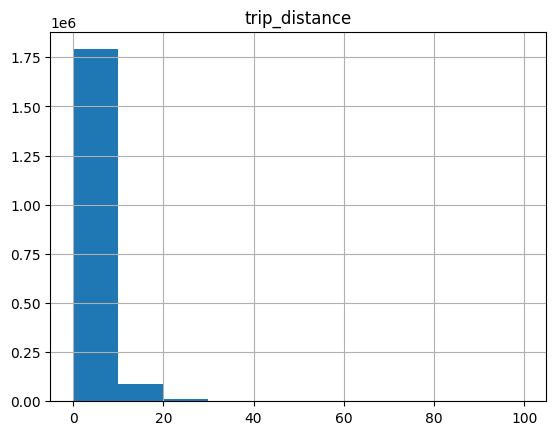

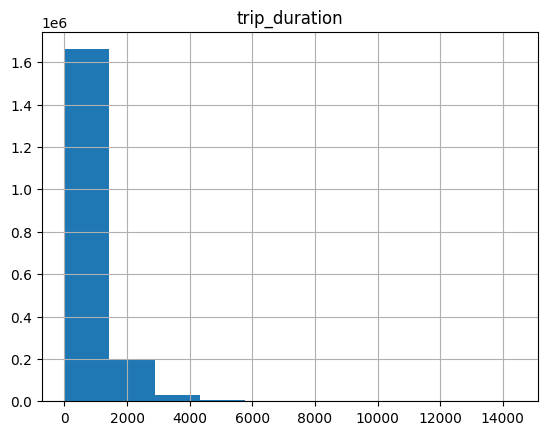

In [35]:
### SAMPLE IMPLEMENTATION ###

from ray.data.preprocessors import *

pd_df = train_dataset.to_pandas(limit=1893433)
pd_df.hist("trip_distance")
pd_df.hist("trip_duration")

sample_preprocessor = PowerTransformer(columns=["trip_distance", "trip_duration"], power=0.5)

Notice the positively-skewed distributions for `trip_distance` and `trip_duration`. For these numerical features, you can choose an appropriate AIR `Preprocessor` depending on your data's properties:

- `PowerTransformer`: your data isn't normal, but you need it to be
- `Normalizer`: you need unit norm rows
- `MinMaxScaler`: you aren't sure what your data looks like

Feature scaling can offer a performance boost during training, and testing choice of `Preprocessor` is worth investigating when you have few features which are not already unit normalized.

**Key Concepts in This Section**

`Dataset`: The standard way to load and exchange data in Ray AIR. In AIR, Datasets are used extensively for data loading, preprocessing, and batch inference.

`Preprocessors`: Preprocessors are primitives that can be used to transform input data into features. Preprocessors operate on Datasets, which makes them scalable and compatible with a variety of datasources and dataframe libraries. A Preprocessor is fitted during Training, and applied at runtime in both Training and Serving on data batches in the same way. AIR comes with a collection of built-in preprocessors, and you can also define your own with simple templates which you can read more about in our [User Guide](https://docs.ray.io/en/latest/ray-air/preprocessors.html).

## 2. Ray Train
***

![Train Highlight](../_static/assets/Introduction_to_Ray_AIR/train_highlight.png)

Following data preprocessing, we can move forward with defining our model for binary classification of big tip rides.

[Ray Train](https://docs.ray.io/en/latest/ray-air/trainer.html) is a library for distributed training on Ray. It offers key tools for different parts of the training workflow, from feature processing, to scalable training, to integrations with ML tracking tools, to export mechanisms for models.

Ray AIR `Trainer`s enable users to distribute training with popular machine learning frameworks like PyTorch, Tensorflow, XGBoost, HuggingFace Transformers, Scikit-Learn, and more. Train supports features like callbacks for early stopping, checkpointing, and integration with Tensorboard, Weights/Biases, and MLflow for observability.

ML pracitioners tend to run into a few common problems with training models that prompt them to consider distributed solutions:

1. training time is too long to be practical
2. the data is too large to fit on one machine
3. the model itself is too large to fit on a single machine

Ray Train tackles the first problem by running distributed multi-node training with fault tolerance, leveraging Ray Data to scale preprocessing and distributed data ingestion. It is also composable with Ray Tune for scaling hyperparameter tuning and outputs the trained model in the form of a `Checkpoint` for batch inference.

In *Figure 4* below, you see that training comes in two major parts: defining the `Trainer` object and then fitting it to the training dataset. In this code snippet, we use a `TorchTrainer`, however, this may be swapped out with any [integrations](https://docs.ray.io/en/latest/ray-air/package-ref.html#trainer-and-predictor-integrations).

![Ray Train Code Snippet](../_static/assets/Introduction_to_Ray_AIR/train_code.png)

*Figure 4*

Let's put these concepts in practice by applying it to our taxi problem.

### 2(a). Define AIR `Trainer`

There are three broad categories of Trainers that AIR offers:

- Deep Learning Trainers (Pytorch, Tensorflow, Horovod)
- Tree-based Trainers (XGBoost, LightGBM)
- Other ML frameworks (HuggingFace, Scikit-Learn, RLlib)

In the example below, we will use an `XGBoostTrainer`to perform binary classification on these NYC Taxi rides. To construct a `Trainer`, you provide:

- a `ScalingConfig` which specifies how many parallel training workers and what type of resources (CPUs/GPUs) to use per worker during training.
- a collection of datasets and a preprocessor for the provided datasets which configures preprocessing and the datasets to ingest from

Optionally, you can choose to add `resume_from_checkpoint` which is a checkpoint path to resume from, should your training run be interrupted.

Below, we'll set up an `XGBoostTrainer` for our classification task. [XGBoost](https://xgboost.readthedocs.io/en/stable/) is a gradient boosted decision trees library. We'll then supply our `Preprocessor` from the previous step as well as training and validation datasets to ingest.

In [ ]:
from ray.air.config import ScalingConfig
from ray.train.xgboost import XGBoostTrainer

trainer = XGBoostTrainer(

    label_column="is_big_tip",
    num_boost_round=100,

    scaling_config=ScalingConfig(
        # number of workers to use
        num_workers=8,
        # whether to use GPU acceleration
        use_gpu=False),

    # XGBoost specific params
    params={
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "error"],
        "tree_method": "approx"
    },

    # feed in our datasets and preprocessor
    datasets={"train": train_dataset, "valid": valid_dataset},
    preprocessor=preprocessor
)

### 2(b). Fit the Trainer

To invoke training, call `.fit()`. Trainer objects produce a `Result` object which gives you access to metrics, checkpoints, and errors.

In [ ]:
result = trainer.fit()

**Coding Exercise**

You can check out the training results from the `Result` object with the following calls:

```python
# returns last saved checkpoint
result.checkpoint

# returns the `n` best saved checkpoints as configured in `RunConfig.CheckpointConfig`
result.best_checkpoints

# returns the final metrics as reported
result.metrics

# returns the contain an Exception if training failed
result.error
```

Inspect your training result below. What is the reported accuracy for the training and validation runs? Note: `error` is the binary classification error rate in this case calculated as `#(wrong cases)/#(all cases)`

In [ ]:
### YOUR CODE HERE ###

**Solution**

CODING SOLUTION AND EXPLANATION FOR RESULT PROBE

In [ ]:
### MY CODE HERE ###

**Coding Exercise**

MORE ADVANCED CODING EXERCISE GOES HERE

In [ ]:
### YOUR CODE HERE ###

**Solution**

CODING SOLUTION AND EXPLANATION FOR MORE ADVANCED PROBLEM HERE

In [ ]:
### MY CODE HERE ###

**Key Concepts in This Section**

`Trainer`: Trainers are wrapper classes around third-party training frameworks such as XGBoost, Pytorch, and Tensorflow. They are built to help integrate with core Ray Actors (for distribution), Ray Tune, and Ray Datasets.

## 3. Ray Tune
***

![Tune Highlight](../_static/assets/Introduction_to_Ray_AIR/tune_highlight.png)

Now that we have a baseline XGBoost model trained, we find the classification accuracy lacking. Among several methods to improve performance (collecting more data, feature engineering, choosing a different algorithm, transfer learning, etc.), **hyperparameter tuning** involves inserting the training loop into an optimization method to find the optimal set of hyperparameters and can be a powerful way to run experiements to achieve good results.

*Hyperparameters*, unlike model parameters which are learned by the model as it trains, are parameters that *you, the human* set. These hyperparameters remain static through a `trial` or experiement and influence the final outcome of training. For example, some common variables to adjust could include:

- `max_depth` in decision tree models
- `drop_out` rate in neural networks
- `discount_factor` in Q-learning
- `num_iterations` in logistic regression
- `n_grams` size of "n" in natural language processing

Setting up and executing hyperparameter optimization (HPO) in itself can be expensive in terms of compute resources and runtime, but there are several intricacies in making the process work *well*, including:

- **Vast Search Space**: your model could have anywhere between a handful to several dozen available hyperparameters, each with different data types and ranges. Some parameters might be correlated. Sampling good candidates from high-dimensional spaces is difficult.
- **Search Algorithms**: choosing hyperparameters at random can work surprisingly well, but in general, you need to test complex search algirhtms to achieve the best result.
- **Long Runtime**: even if you distribute tuning, training complex models in themselves can take a long time to complete per run, so it's best to have an efficiency at every stage in the pipeline.
- **Resource Allocation**: you must have enough compute resources available to during each trial as to not slow down search because of scheduling mismatches.
- **User Experience**: HPO is complicated, and visibility and tooling for developers like stopping bad runs early, saving intermediate results, restarting from checkpoints, or pausing and resume runs makes the process easier on the human.

Ray Tune is a distributed HPO library that addresses all of these topics above to provide a simplified interface for running trials and integrates with popular frameworks such as HyperOpt, Optuna, and many more.

In *Figure 5*, you'll find the general pattern for using AIR `Tuner`s which involves taking in a trainable, defining a search space, establishing a search algorithm, scheduling trials, and analyzing results. We'll go over the relevant components in the following section.

![Ray Tune Code Snippet](../_static/assets/Introduction_to_Ray_AIR/tune_code.png)

*Figure 5*

Let's see how to interact with Ray Tune to make some improvements to our big tip classifier.

### 3(a). Use AIR `Tuner` for Hyperparameter Search

To set up an AIR `Tuner`, we must specify:

- `search space`: a set of hyperparameters you wish to tune
- `search_algorithm`: to optimize parameter search
- `scheduler`: (optional) to stop searches early and speed up experiments

We pass the `search space`, `search algorithm`, `scheduler`, and `Trainer` to the `Tuner`, which runs the workload by evaluating multiple hyperparameters in parallel. Afterwards, `Tuner` returns its results in a `ResultGrid` for you to analyze.

Below, we'll define a search space with a few hyperparameters to tune. 

- `eta` is the learning rate
- `max_depth` specifies how deep each tree is with a default of 6. A higher value leads to a more complex model. Using `tune.randint(1, 9)`, it will sample an integer uniformly between 1 and 9, inclusive.
- `min_child_weight` defines the minimum sum of weights of all observations in a child, used to control overfitting

In [ ]:
from ray import tune
from ray.tune.tuner import Tuner, TuneConfig

param_space = {"params":
    {
    "eta": tune.uniform(0.2, 0.4),
    "max_depth": tune.randint(1, 9),
    "min_child_weight": tune.uniform(0.8, 1.0)
    }
}

tuner = Tuner(
    trainer,
    param_space=param_space,
    tune_config=TuneConfig(num_samples=10, metric="train-logloss", mode="min"),
)

### 3(b). Execute Hyperparameter Search & Analyze Results

Now, we can execute tuning on our 10 trials. After tuning, we can query the `ResultGrid` object to see metrics, results, and checkpoints of each trial.

In [ ]:
result_grid = tuner.fit()

# checks if there have been errors
result_grid.errors

# gets the best result
best_result = result_grid.get_best_result()

# gets the best checkpoint
best_checkpoint = best_result.checkpoint

# gets the best metrics
best_metrics = best_result.metrics

**Coding Exercise**

SIMPLE CODING EXERCISE WITH TUNE GOES HERE

In [ ]:
### YOUR CODE HERE ###

**Solution**

SIMPLE CODING EXERCISE SOLUTION AND EXPLANATION GOES HERE

In [ ]:
### MY CODE HERE ###

**Coding Exercise**

`Tuner` allows you to specify an optimization algorithm via the `TuneConfig` by setting the following flags:

- `search_alg` which provides an optimizer for selecting the optimal hyperparameters
- `scheduler` which provides a scheduling/resource allocation algorithm for accelerating the search process

Read more about [schedulers](https://docs.ray.io/en/latest/tune/key-concepts.html#schedulers-ref) and [search algorithms](https://docs.ray.io/en/latest/tune/key-concepts.html#search-alg-ref) in Ray AIR and implement them on this example to see a difference in results.

In [ ]:
### YOUR CODE HERE ###

**Solution**

SOLUTION FOR SCHEDULER GOES HERE

In [ ]:
### MY CODE HERE ###

**Key Concepts in This Section**

`Tuner`: provides an interface that works with AIR `Trainer`s to perform distributed hyperparameter tuning. You define a set of hyperparameters you wish to tune in a search space, specify a search algorithm, and the `Tuner` returns its results in a `ResultGrid` that contains metrics, results, and checkpoints for each `trial`.

## 4. Ray AIR Predictors
***

Ray AIR Predictors load models from your [checkpoints](https://docs.ray.io/en/latest/ray-air/key-concepts.html#air-checkpoints-doc) generated during training or tuning to perform distributed inference.

During batch prediction, the input batch is converted into a Pandas DataFrame. If there is a `Preprocessor` saved in the provided `Checkpoint`, the preprocessor will be used to transform the DataFrame. The transformed DataFrame is then passed to the model for ingerence and outputted predictions will be of the same type as the original input.

In *Figure 6*, you can see how `BatchPredictor` is passed a `Checkpoint` and `Predictor`.

![Batch Predictor Code Snippet](../_static/assets/Introduction_to_Ray_AIR/batchpredict_code.png)

*Figure 6*

### Use AIR `BatchPredictor` for Batch Prediction
Previously, we have trained and tuned our XGBoost model on data from June 2021. Let's now take out best checkpoint from the tuning step and perform batch inference on taxi tip data from June 2022.

In [ ]:
from ray.train.batch_predictor import BatchPredictor
from ray.train.xgboost import XGBoostPredictor

batch_predictor = BatchPredictor.from_checkpoint(best_result.checkpoint, XGBoostPredictor)

test_dataset = ray.data.read_parquet("s3://anyscale-training-data/intro-to-ray-air/nyc_taxi_2022.parquet").drop_columns("is_big_tip")

predicted_probabilities = batch_predictor.predict(test_dataset)
print("PREDICTED PROBABILITIES")
predicted_probabilities.show()

**Coding Exercise**

Now that you have the predictions generated from the testing set, how did we do? Compare the predictions outputted by `BatchPredictor` with the ground truth labels available in the raw data file.

In [ ]:
### YOUR CODE HERE ###

**Solution**

SOLUTION AND EXPLANATION FOR BATCHPREDICT EXERCISE GOES HERE

In [ ]:
### MY CODE HERE ###

**Key Concepts in This Section**

`Checkpoints`: store the full state of the model periodically, so that partially trained models are available and can be used to resume training from an intermediate point, instead of starting from scratch; also allows for the best model to be saved for batch inference later on

`BatchPredictor`: loads the best model from a checkpoint to perform batch inference on large-scales or online inference

## 5. Ray Serve
***

![Serve Highlight](../_static/assets/Introduction_to_Ray_AIR/serve_highlight.png)

Finally, we want a way to serve our taxi tip prediction application to our end users, hopefully with a low latency to be maximally useful to drivers on the job. However, this poses a challenge since machine learning models are compute intensive and ideally, this model wouldn't be served in isolation, but rather adjacent to business logic or even other ML models.

Ray Serve is a scalable compute layer for sercing machine learning models that allows you to serve individual models or create composite model pipelines, where you can independently deploy, update, and scale individual components. Serve isn't tied to a specific machine learning library, but rather treats models as ordinary Python code. 

Additionally, it allows you to flexibly combine normal Python business logic alongside machine learning models. This makes it possible to build online inference services completely end-to-end: a Serve application could validate user input, query a database, perform inference scalably across multiple ML models, and combine, filter, and validate the output all in the process of handling a single inference request.

In *Figure 7*, you see the pattern for deploying a `Predictor` from a `Checkpoint` wth Ray Serve.

![Ray Serve Code Snippet](../_static/assets/Introduction_to_Ray_AIR/serve_code.png)

*Figure 7*

Let's deploy our big tip predictor with Ray Serve.

### 5(a) Use `PredictorDeployment` for Online Inference
Deploy the best model as an inference service by using Ray Serve and the `PredictorDeployment` class. After deploying the service, you can send requests to it.

In [ ]:
from ray import serve
from fastapi import Request
from ray.serve import PredictorDeployment
from ray.serve.http_adapters import pandas_read_json

serve.run(
    PredictorDeployment.options(name="XGBoostService", num_replicas=2, route_prefix="/rayair").bind(
        XGBoostPredictor, best_result.checkpoint, http_adapter=pandas_read_json
    )
)

Let's send a request through HTTP. You can use the `PredictorDeployment` to deploy checkpoints trained in Ray AIR as live endpoints.

In [ ]:
import requests

sample_input = test_dataset.take(1)
sample_input = dict(sample_input[0])

output = requests.post("http://localhost:8000/rayair", json=[sample_input]).json()
print(output)

**Coding Exercise**

SIMPLE SERVE CODING EXERCISE HERE

In [ ]:
### YOUR CODE HERE ###

**Solution**

SERVE SOLUTION FOR SIMPLE EXAMPLE HERE

In [ ]:
### MY CODE HERE ###

**Coding Exercise**

We've just served a prediction for a single sample input from our test dataset. Predictors are able to accept array, dataframe, and custom inputs (that can be transformed to array or dataframe). You can also configure micro-batching to enhance performance.

Try reading through the [user guide](https://docs.ray.io/en/latest/ray-air/examples/serving_guide.html) for predictors to accept incoming data via an input format of your choice and serve it from our best checkpoint.

In [ ]:
### YOUR CODE HERE ###

**Solution**

SOLUTION FOR ADVANCED SERVE HERE

In [ ]:
## MY CODE HERE ###

**Key Concepts in This Section**

`Deployments`: you can think of this as a managed group of Ray actors that can be addressed together and will handle requests load-balanced across them.

## Summary
You've now just created a Ray Dataset, preprocessed some features, built a model with XGBoost, searched a hyperparameter space for the best configuration, loaded the best model from a checkpoint to perform batch inference, and served that model for online inference. Through this end-to-end example, you explored how to use Ray AIR to distribute an entire ML pipeline.

### Key Concepts

- `Datasets`
- `Preprocessors`
- `Trainers`
- `Tuner`
- `Checkpoints`
- `BatchPredictor`
- `Deployments`

### Next Up

Now that you've seen how you can use Ray AIR's unified toolkit to scale an end-to-end machine learning application, let's see how we can use it to scale reinforcement learning specific workloads. In the next section we will cover a reinforcement learning example

# Reinforcement Learning on Ray AIR
***
In addition to scaling end-to-end workflows with supervised learning problems, we can use Ray AIR to scale reinforcement learning workloads. Here, we will demonstrate this by training a reinforcement learning agent using online training.

**A Brief Primer on Reinforcement Learning Basics**

Reinforcement learning (RL) involves an **agent** learning what to do through **rewards** based on its interactions from its **environment**. Unlike other types of machine learning, the path to maximize rewards is not prescribed, but rather must be learned through trying and feedback over time. To unpack this further, here are some key componenents of RL problem:

- **Action Space** - all possible actions; could be discrete steps (left, right) or continuous (accelerate $F  \frac{m}{s^2}$)
- **State Space** - a complete description of the environment; a *value function* specifies the value of reward the agent can accumulate in the future starting from that state
- **Observation Space** - an observation by the agent of certain parts of the state
- **Reward** - feedback, positive or negative, after each action; defines the goal
- **Policy** - defines the learning agent's way of behaving based on its expected sum over all future rewards

![Agent/Env](https://docs.ray.io/en/latest/_images/env_key_concept1.png)

We'll go into how to work with these components in the coding exercise. For now, let's chat about how to run reinforcement learning applications with Ray RLlib.


## Ray RLLib
***

![RLlib Highlight](../_static/assets/Introduction_to_Ray_AIR/rllib_highlight.png)

RLlib is an open-source library for reinforcement learning (RL), offering support for [production-level](https://www.anyscale.com/events/2021/06/23/applying-ray-and-rllib-to-real-life-industrial-use-cases), distributed RL workloads while maintaining unified and simple APIs for a large variety of industry applications. As part of the Ray ecosystem, RLlib integrates well with other Ray libraries like Ray Tune for checkpointing and Ray Serve for deploying models.

**Some Key Features of RLlib:**

- **[PyTorch](https://github.com/ray-project/ray/blob/master/rllib/examples/custom_torch_policy.py) and [Tensorflow](https://github.com/ray-project/ray/blob/master/rllib/examples/custom_tf_policy.py)** - available as backends, with the option to switch between them with one line of code
- **Hightly Distributed** - inherits from Ray Core and allows you to configure `num_workers` to run on hundreds of nodes
- **Vectorized and Remote Environments** - batched and parallel environments that auto-vectorizes `gym.Envs` via the `num_envs_per_worker` config
- **Support for Multi-Agent** - convert custom `gym.Envs` into a multi-agent set-up to start training with cooperative policies, adversarial scenarios, and/or independent learning
- **External Simulators** - support for external environment API and comes with a pluggable, off-the-shelf client/server setup that allows you to run hundreds of independent simulators on the "outside" connecting to a central RLlib Policy-Server that learns and serves actions.
- **Offline Support** - comes with several offline algorithms (CQL, MARWIL, and DQfD) allowing either behavior-cloning an existing system or learning how to improve it
- [**Algorithms**](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html) - a growing collection of 25+ algorithms to apply in offline, model-free on-policy, model-free off-policy, model-based, derivative-free, recommender systems, contextual bandits, multi-agent, and other RL
- [**Environments**](https://docs.ray.io/en/latest/rllib/rllib-env.html) - support for several different types of environments including OpenAI Gym, user-defined, multi-agent, and batch environments

### Example: CartPole Training and Online Evaluation

For our example, we will run training on the [CartPole environment](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) from [OpenAI Gym](https://www.gymlibrary.dev/). The premise is essentially that there is a pole attached to a cart on a frictionless track and the agent's job is to balance this pendulum upright by moving left and right. The observation space consists of the cart position, cart velocity, pole angle, and pole angular velocity, and the goal is to keep the pole upright for as long as possible.

![Cartpole](https://www.gymlibrary.dev/_images/cart_pole.gif)

*Figure 8*

**1(a) Importing Relevant Packages**

In [ ]:
import gym
import numpy as np

from ray.air import RunConfig
from ray.air import ScalingConfig

from ray.air import Checkpoint
from ray.air import Result

from ray.train.rl import RLTrainer
from ray.train.rl import RLPredictor

1. To begin, we'll be using [OpenAI Gym](https://www.gymlibrary.dev/) which is a standard open source Python library for developing and comparing reinforcement learning algorithms as well as providing a standard set of environments.
2. With Ray AIR's `RunConfig` and `ScalingConfig` we can specify configurations for training/tuning runs and scaling training respectively so that your settings are preserved in the pipeline.
3. Callback to `Checkpoint` and `Result` objects from previous sections that store the state of your model and the result from a training or tuning trial.
4. Import RL specific trainers and predictors which are able to take in Ray datasets and preprocessors from prior steps.

Note: We are using a Ray AIR wrapper for RLlib's trainable which allows a smoother integration with the Ray ecosystem. For custom environments, preprocessors, or models, you can check out the [Training APIs for Rllib](https://docs.ray.io/en/latest/rllib/rllib-training.html).

**1(b) Define a Training Function**

In [ ]:
def train_rl(num_workers, use_gpu):
    trainer = RLTrainer(
        run_config=RunConfig(stop={"training_iteration": 5}),
        scaling_config=ScalingConfig(num_workers=num_workers, use_gpu=use_gpu),
        algorithm="PPO",
        config={
            "env": "CartPole-v1",
            "framework": "tf",
        },
    )
    
    return trainer.fit()

We can define a training function, `train_rl()` that takes in:
- `num_workers`: int, the number of workers to start
- `use_gpu`: bool, whether to use gpu

and creates an `RLTrainer`, similar to the `Trainer` object we encountered in the Ray Train section, which specifies:

- `RunConfig`: sets up how the training run should happen
- `ScalingConfig`: allows you to adjust settings for how to scale training
- `algorithm`: we use the [`PPO` algorithm](https://openai.com/blog/openai-baselines-ppo/)
- `config`: specifies our `CartPole-v1` environment and uses Tensorflow as a our backend

When we call `train_rl()`, it returns a `Result` object automatically created by `trainer.fit()` through which we can access a `Checkpoint` of the trained model.

**1(c) Define an Evaluation Function**

Next, we want to create a function to evaluate how well our model trained. It's performance will be evaluated on a reset version of the same environment. In this online evaluation technique, unlike supervised learning cases where we evaluate on a static test set, we probe how well the agent performs through a live simulation.

In [ ]:
def evaluate(checkpoint, num_episodes):
    predictor = RLPredictor.from_checkpoint(checkpoint)

    env = gym.make("CartPole-v1")

    rewards = []
    for i in range(num_episodes):
        obs = env.reset()
        reward = 0.0
        done = False
        while not done:
            action = predictor.predict(np.array([obs]))
            obs, r, done, _ = env.step(action[0])
            reward += r
        rewards.append(reward)

    return rewards

We create an `evaluate()` function that takes in:
- `checkpoint`: the saved model state from the training `Result`
- `num_episodes`: the number of episodes to run, i.e. agent-environment iteration cycles

To begin, we:

- Create an `RLPredictor` from the `checkpoint`
- Set the environment to `CartPole-v1`
- Create a list of rewards for each episode

For every episode:
- `env.reset()` - the observation state is reset to a uniformly random value `(-0.05, 0.05)` for cart position, cart velocity, pole angle, and pole angular velocity
- set `reward` to 0 and `done` flag to `False`

While we're not in a terminal state:
- take an action based on the trained model's best judgement of the observation space
- obtain a new observation state, reward, and done flag after taking a step
- we assign a reward of `+1` for every step taken, including the termination step

<!-- **Example Terminal States**

1. Termination: Pole Angle is greater than $\pm 12 \degree$
2. Termination: Cart Position is greater than $\pm2.4$ (center of the cart reaches the edge of the display)
3. Truncation: Episode length is greater than 500 (200 for v0) -->

**1(d) Online Reinforcement Learning**

Finally, let's put it all together to train the model, evaluate the policy on a fresh environment (using the checkpoint from training) for `num_episodes`. For `CartPole-v1`, the reward threshold is set to `+475`, so let's see how we stack up!

In [ ]:
num_episodes = 3

result = train_rl(num_workers=8, use_gpu=False)
rewards = evaluate(result.checkpoint, num_episodes=num_episodes)

print(f"Average Reward Over {num_episodes} Episodes: " f"{np.mean(rewards)}")

**Coding Exercise**

SIMPLE CODING EXERCISE

In [ ]:
### YOUR CODE HERE ###

**Solution**

SIMPLE CODING EXERCISE SOLUTION AND EXPLANATION for RLlib

In [ ]:
### MY CODE HERE ###

**Coding Exercise**

We have mostly kept this example to focus on RLlib, but we can definitely apply our learnings from previous sections to extend this solution. RLlib integrates particularly well with Ray Tune.

Modify the function `train_rl(num_workers, use_gpu)` we created above to include a tuning step. Some things that will help you along the way:

- RLlib Trainers can be passed into the first argument when instantiating a `Tuner` object.
- We want a `Checkpoint` at the end of tuning to access later on in our evaluation step, so turn this parameter to `True`
- Remember that Tuner returns a `ResultGrid` that contains all the results from your training run. You can either elect to return the first result, or better yet, return the best result by querying `result_grid.get_best_result()`

In [ ]:
from ray import tune

def train_rl(num_workers, use_gpu):
    trainer = RLTrainer(
        run_config=RunConfig(stop={"training_iteration": 5}),
        scaling_config=ScalingConfig(num_workers=num_workers, use_gpu=use_gpu),
        algorithm="PPO",
        config={
            "env": "CartPole-v1",
            "framework": "tf",
        },
    )
    
    ### MODIFY TRAIN_RL HERE ###

    return trainer.fit()

**Solution**

SOLUTION w/ EXPLANATION GOES HERE

In [ ]:
### MY CODE HERE ###

### Summary

In this section, we trained a reinforcement learning agent using online training in a Cartpole environment.

#### Key Concepts

Reinforcement Learning Concepts
- Agent
- Action Space
- State Space
- Observation Space
- Reward
- Policy

Ray RLlib Concepts
- `RunConfig`
- `ScalingConfig`
- `Checkpoint`
- `Result`
- `RLTrainer`
- `RLPredictor`

# Extra Resources
---
If you would like to practice your new skills further with some in-depth examples beyond the embedded coding exercises, take a look at this list of suggested problems:
- Watch the Ray Summit Talk on [Introduction to Ray AIR](https://github.com/ray-project/hackathon5-algo)
- Check out the [Ray AIR Documentation](https://docs.ray.io/en/latest/ray-air/getting-started.html)
- Understand its [Components and APIs](https://docs.ray.io/en/latest/ray-air/package-ref.html)
- Ray AIR [User Guides](https://docs.ray.io/en/latest/ray-air/user-guides.html) and [Examples](https://docs.ray.io/en/latest/ray-air/examples/index.html)


# Next Steps
---
Congratulations! You have completed the tutorial on an Introduction to Ray AI Runtime! We dicussed each library in Ray AIR (Data, Train, Tune, Serve, RLLib) and saw some example machine learning workloads to be done with each. In the next module, we will introduce the ecosystem of integrated libraries runs on Ray Core's distributed execution engine, and with Ray Clusters, you can deploy your workloads on AWS, GCP, Azure, or on Kubernetes.

From here, you can learn and get more involved with our active community of developers and researchers by checking out the following resources:
- [Official Ray Website](https://www.ray.io/): Browse the ecosystem and use this site as a hub to get the information that you need to get going and building with Ray.
- [Join the Community on Slack](https://forms.gle/9TSdDYUgxYs8SA9e8): Find friends to discuss your new learnings in our Slack space.
- [Use the Discussion Board](https://discuss.ray.io/): Ask questions, follow topics, and view announcements on this community forum.
- [Join a Meetup Group](https://www.meetup.com/Bay-Area-Ray-Meetup/): Tune in on meet-ups to listen to compelling talks, get to know other users, and meet the team behind Ray.
- [Open an Issue](https://github.com/ray-project/ray/issues/new/choose): Ray is constantly evolving to improve developer experience. Submit feature requests, bug-reports, and get help via GitHub issues.